## RMSEで学習
rmseの方が、noiseに頑健

In [2]:
!nvidia-smi

Mon Dec 20 10:06:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install timm pytorch-lightning==1.4.0 grad-cam ttach

     |████████████████████████████████| 376 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 913 kB 62.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 63.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.5-py3-none-any.whl size=22419 sha256=f2daec88228c3144b97afd1999eaec3b7930c2ff871b95260c7c484cfb71394c
  Stored in directory: /root/.cache/pip/wheels/89/d1/a6/41cb46183c56fe9e78ba80781ca35c3bc2728406b694fb7a13
Successfully built grad-cam
^C
ERROR: Operation cancelled by user


In [3]:
!pip install ../input/hydracore105/omegaconf-2.0.5-py3-none-any.whl

Processing /kaggle/input/hydracore105/omegaconf-2.0.5-py3-none-any.whl
omegaconf is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
!wandb login 3c9215da30bbfcdbda55dedbd13a788ae6985aea

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import os
import warnings
from pprint import pprint
from glob import glob
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from timm import create_model
from sklearn.model_selection import StratifiedKFold
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

from omegaconf import OmegaConf

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule

from pytorch_lightning.loggers import WandbLogger
import wandb


warnings.filterwarnings("ignore")

In [6]:
# wandb setting
wandb.init(
    project="petfinder",
    entity="takeru",
    id="2021_12_19_rmse",
)
wandb_logger = WandbLogger()

wandb: Currently logged in as: takeru (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-12-20 04:22:17.074894: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## config

In [7]:
config = {'seed': 72,
          'root': '/kaggle/input/petfinder-pawpularity-score/', 
          'n_splits': 5,
          'epoch': 10,
          'trainer': {
              'gpus': 1,
              'accumulate_grad_batches': 2,
              'progress_bar_refresh_rate': 1,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None,
          },
          'transform':{
              'name': 'get_default_transforms',
              'image_size': 224
          },
          'train_loader':{
              'batch_size': 32,
              'shuffle': True,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': True,
          },
          'val_loader': {
              'batch_size': 32,
              'shuffle': False,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': False
         },
          'model':{
              'name': 'swin_large_patch4_window7_224',
              'output_dim': 1
          },
          'optimizer':{
              'name': 'optim.AdamW',
              'params':{
                  'lr': 1e-5
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 10,
                  'eta_min': 1e-4,
              }
          }
}

config = OmegaConf.create(config)

In [8]:
pprint(config)

{'seed': 72, 'root': '/kaggle/input/petfinder-pawpularity-score/', 'n_splits': 5, 'epoch': 10, 'trainer': {'gpus': 1, 'accumulate_grad_batches': 2, 'progress_bar_refresh_rate': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0, 'resume_from_checkpoint': None}, 'transform': {'name': 'get_default_transforms', 'image_size': 224}, 'train_loader': {'batch_size': 32, 'shuffle': True, 'num_workers': 4, 'pin_memory': False, 'drop_last': True}, 'val_loader': {'batch_size': 32, 'shuffle': False, 'num_workers': 4, 'pin_memory': False, 'drop_last': False}, 'model': {'name': 'swin_large_patch4_window7_224', 'output_dim': 1}, 'optimizer': {'name': 'optim.AdamW', 'params': {'lr': 1e-05}}, 'scheduler': {'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts', 'params': {'T_0': 20, 'eta_min': 0.0001}}}


## dataset

In [9]:
class PetfinderDataset(Dataset):
    def __init__(self, df, image_size=224):
        self._X = df["Id"].values
        self._y = None
        if "Pawpularity" in df.keys():
            self._y = df["Pawpularity"].values
        self._transform = T.Resize([image_size, image_size])

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        image = read_image(image_path)
        image = self._transform(image)
        if self._y is not None:
            label = self._y[idx]
            return image, label
        return image

class PetfinderDataModule(LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

    def __create_dataset(self, train=True):
        return (
            PetfinderDataset(self._train_df, self._cfg.transform.image_size)
            if train
            else PetfinderDataset(self._val_df, self._cfg.transform.image_size)
        )

    def train_dataloader(self):
        dataset = self.__create_dataset(True)
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(False)
        return DataLoader(dataset, **self._cfg.val_loader)

## visualize data

In [10]:
torch.autograd.set_detect_anomaly(True)
seed_everything(config.seed)

# cutting_dataset = "../input/petfinder2-cropped-dataset/crop"
dataset_dir = "../input/petfinder-pawpularity-score/train"

df = pd.read_csv(os.path.join(config.root, "train.csv"))
df["Id"] = df["Id"].apply(lambda x: os.path.join(dataset_dir, x + ".jpg"))

## CatとDogのラベルを付与

In [11]:
cat_dog = pd.read_csv('../input/cat-vs-dog/train_with_type.csv')

In [12]:
df["cat_dog"] = cat_dog["pred_label"]

## augmentation

In [13]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB


def get_default_transforms():
    transform = {
        "train": T.Compose(
            [
                T.RandomHorizontalFlip(),
#                 T.RandomVerticalFlip(),
#                 T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
        "val": T.Compose(
            [
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
    }
    return transform


## model

In [14]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [15]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.fold = cfg.fold
        self.__build_model()
        self._criterion = petfinder_rmse
        self.transform = get_default_transforms()
        self.save_hyperparameters(cfg)

    def __build_model(self):
        self.backbone = create_model(
            self.cfg.model.name, pretrained=True, num_classes=1, in_chans=3
        )
#         num_features = self.backbone.num_features
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5), nn.Linear(num_features, self.cfg.model.output_dim)
#         )

    def forward(self, x):
        out = self.backbone(x)
#         out = self.fc(f)
        return out

    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        return {'loss': loss, 'pred': pred, 'labels': labels}
        
    def validation_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'val')
        return {'pred': pred, 'labels': labels}
    
    def __share_step(self, batch, mode):
        images, labels = batch
        labels = labels.float() / 100.0
        images = self.transform[mode](images)
        
        if torch.rand(1)[0] < 0.5 and mode == 'train':
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
            logits = self.forward(mix_images).squeeze(1)
            loss = self._criterion(logits, target_a) * lam + \
                (1 - lam) * self._criterion(logits, target_b)
        else:
            logits = self.forward(images).squeeze(1)
            loss = self._criterion(logits, labels)
        
        pred = logits.sigmoid().detach().cpu() * 100.
        labels = labels.detach().cpu() * 100.
        return loss, pred, labels
        
    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        preds = []
        labels = []
        for out in outputs:
            pred, label = out['pred'], out['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        metrics = torch.sqrt(((labels - preds) ** 2).mean())
        self.log(f"fold{self.fold}/{mode}_loss", metrics)
    
    def check_gradcam(self, dataloader, target_layer, target_category, reshape_transform=None):
        cam = GradCAMPlusPlus(
            model=self,
            target_layer=target_layer, 
            use_cuda=self.cfg.trainer.gpus, 
            reshape_transform=reshape_transform)
        
        org_images, labels = iter(dataloader).next()
        cam.batch_size = len(org_images)
        images = self.transform['val'](org_images)
        images = images.to(self.device)
        logits = self.forward(images).squeeze(1)
        pred = logits.sigmoid().detach().cpu().numpy() * 100
        labels = labels.cpu().numpy()
        
        grayscale_cam = cam(input_tensor=images, target_category=target_category, eigen_smooth=True)
        org_images = org_images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255.
        return org_images, grayscale_cam, pred, labels

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## train

In [16]:
def trans_cat_dog_label(x):
    if x == 0:
        return 0
    else:
        return 200

df["cat_dog"] = df["cat_dog"].apply(trans_cat_dog_label)

In [17]:
df["fold_value"] = df["Pawpularity"] + df["cat_dog"]

count    9912.000000
mean      143.143967
std       101.948379
min         1.000000
25%        34.000000
50%       212.000000
75%       234.000000
max       300.000000
Name: fold_value, dtype: float64



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



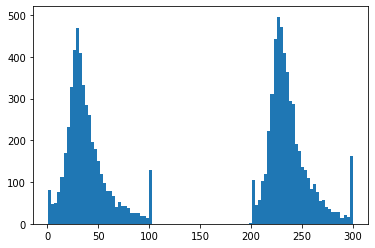

In [18]:
print(df["fold_value"].describe())
plt.figure()
plt.hist(df["fold_value"], bins=100)
plt.show()

In [ ]:
skf = StratifiedKFold(
    n_splits=config.n_splits, shuffle=True, random_state=config.seed
)

for fold, (train_idx, val_idx) in enumerate(skf.split(df["Id"], df["fold_value"])):
    config.fold = fold
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)
    datamodule = PetfinderDataModule(train_df, val_df, config)
    model = Model(config)
    earystopping = EarlyStopping(monitor=f"fold{fold}/val_loss")
    lr_monitor = callbacks.LearningRateMonitor()
    loss_checkpoint = callbacks.ModelCheckpoint(
        filename="best_loss",
        monitor=f"fold{fold}/val_loss",
        save_top_k=1,
        mode="min",
        save_last=False,
    )
    logger = wandb_logger
    
    trainer = pl.Trainer(
        logger=logger,
        max_epochs=config.epoch,
        callbacks=[lr_monitor, loss_checkpoint, earystopping],
        **config.trainer,
    )
    trainer.fit(model, datamodule=datamodule)

Training: -1it [00:00, ?it/s]